In [ ]:
import tensorflow as tf
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


# Descarcare DATASET

In [ ]:
import os
import kagglehub
import shutil

os.environ['KAGGLE_USERNAME'] = "ionutcasapiu"
os.environ['KAGGLE_KEY'] = "25423583930c0ceabe64e4c7a02f6eda"
print("Variabilele de mediu Kaggle setate.")

original_dataset_path = None
dataset_name_to_download = "ionutcasapiu/crop-leaf-disease-general"
fallback_dataset_path = "/kaggle/input/plant-disease-recognition-dataset"

try:
    path_object = kagglehub.dataset_download(dataset_name_to_download)
    original_dataset_path = str(path_object)
    print(f"Dataset '{dataset_name_to_download}' descărcat în: {original_dataset_path}")
except Exception as e:
    print(f"Eroare la descărcarea '{dataset_name_to_download}': {e}")
    if os.path.exists(fallback_dataset_path):
        original_dataset_path = fallback_dataset_path
        print(f"Se folosește fallback: {original_dataset_path}")
    else:
        print(f"Descărcarea și fallback-ul au eșuat.")

new_dataset_path = None
if original_dataset_path and os.path.exists(original_dataset_path):
    base_folder_name = dataset_name_to_download.split('/')[-1] if dataset_name_to_download in original_dataset_path else os.path.basename(str(original_dataset_path).rstrip('/'))
    new_dataset_path = f"/content/{base_folder_name}"

    if os.path.exists(new_dataset_path):
        shutil.rmtree(new_dataset_path)
        print(f"Directorul existent '{new_dataset_path}' a fost șters.")

    try:
        if os.path.isdir(original_dataset_path):
            shutil.copytree(original_dataset_path, new_dataset_path)
            print(f"Dataset copiat în '{new_dataset_path}'.")
        else: # Ar putea fi un fișier dacă kagglehub se schimbă sau fallback-ul e un fișier
            os.makedirs(os.path.dirname(new_dataset_path), exist_ok=True)
            shutil.copy2(original_dataset_path, new_dataset_path)
            print(f"Fișier dataset copiat în '{new_dataset_path}'.")
    except Exception as e:
        print(f"Eroare la copierea datasetului: {e}")
        new_dataset_path = None
else:
    print("Nicio sursă validă pentru dataset. Copierea nu va avea loc.")

if new_dataset_path and os.path.exists(new_dataset_path):
    print(f"Proces finalizat. Dataset disponibil la: {new_dataset_path}")
else:
    print("Procesul nu s-a finalizat cu succes.")

Variabilele de mediu Kaggle setate.


100%|██████████| 1.59G/1.59G [00:12<00:00, 133MB/s]

Extracting files...


Dataset 'ionutcasapiu/crop-leaf-disease-general' descărcat în: /root/.cache/kagglehub/datasets/ionutcasapiu/crop-leaf-disease-general/versions/2
Dataset copiat în '/content/crop-leaf-disease-general'.
Proces finalizat. Dataset disponibil la: /content/crop-leaf-disease-general


In [ ]:
# Folosește copytree pentru a copia dacă nu există deja la destinație
if not os.path.exists(new_dataset_path):
    # Asigură-te că sursa există înainte de a încerca copierea
    if os.path.exists(original_dataset_path):
        print(f"Copiez datasetul din {original_dataset_path} în {new_dataset_path}...")
        try:
            shutil.copytree(original_dataset_path, new_dataset_path)
            print(f"Dataset copiat cu succes în: {new_dataset_path}")
            data_dir = new_dataset_path
        except Exception as e_copy:
            print(f"EROARE la copierea datasetului: {e_copy}")
            # Poate oprește scriptul sau setează data_dir la o cale alternativă dacă există
            data_dir = None # Indică o problemă
    else:
        print(f"EROARE: Calea sursă '{original_dataset_path}' nu există. Verifică calea.")
        data_dir = None # Indică o problemă
else:
    print(f"Datasetul există deja la: {new_dataset_path}")
    data_dir = new_dataset_path

# Oprește execuția dacă data_dir nu a putut fi setat
if data_dir is None:
    print("Directorul cu date nu este valid. Se oprește execuția.")
    exit()


Datasetul există deja la: /content/crop-leaf-disease-general


# Validare Imagini

In [ ]:
print("\n--- Pornesc validarea imaginilor ---")
subsets = ["/content/crop-leaf-disease-general/dataset/Train/Train", "/content/crop-leaf-disease-general/dataset/Validation/Validation", "/content/crop-leaf-disease-general/dataset/Test"]
removed_files_count = 0

for subset in subsets:
    subset_path = os.path.join(data_dir, subset)
    if not os.path.exists(subset_path):
        print(f"Atenție: Calea pentru subset '{subset_path}' nu a fost găsită, se sare peste.")
        continue

    print(f"Se verifică subsetul: {subset}")
    for image_class in os.listdir(subset_path):
        class_path = os.path.join(subset_path, image_class)
        if not os.path.isdir(class_path):
            continue
        for image_file_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file_name)
            if not os.path.isfile(image_path):
                 continue
            try:
                img = cv2.imread(image_path)
                if img is None:
                    print(f'(!) Problemă imagine (cv2 nu a putut citi): {image_path}')
                    #ȘTERGE fișierul CU problemE
                    try:
                        os.remove(image_path)
                        removed_files_count += 1
                        print(f'    -> Fișier șters: {image_path}')
                    except OSError as e_remove:
                        print(f'    -> EROARE la ștergere: {e_remove}')
            except Exception as e:
                print(f'(!) Problemă imagine (excepție la procesare): {image_path}, Eroare: {e}')
                # ȘTERGE fișierul cu probleme
                try:
                    os.remove(image_path)
                    removed_files_count += 1
                    print(f'    -> Fișier șters: {image_path}')
                except OSError as e_remove:
                    print(f'    -> EROARE la ștergere: {e_remove}')

print(f"Validarea imaginilor s-a terminat. Fișiere problematice raportate (dacă există).")
if removed_files_count > 0:
    print(f"Au fost șterse {removed_files_count} fișiere problematice.")



--- Pornesc validarea imaginilor ---
Se verifică subsetul: /content/crop-leaf-disease-general/dataset/Train/Train
Se verifică subsetul: /content/crop-leaf-disease-general/dataset/Validation/Validation
Se verifică subsetul: /content/crop-leaf-disease-general/dataset/Test
Validarea imaginilor s-a terminat. Fișiere problematice raportate (dacă există).


In [ ]:
# --- Definire Căi pentru Generatoare ---
print("\n--- Definire căi pentru generatoare ---")
train_dir = os.path.join(data_dir, "dataset/Train", "Train")
valid_dir = os.path.join(data_dir, "dataset/Validation", "Validation")
test_dir = os.path.join(data_dir, "dataset", "Test")

# Verificăm existența folderelor
print(f"Verific Train: {train_dir} - Există? {os.path.exists(train_dir)}")
print(f"Verific Valid: {valid_dir} - Există? {os.path.exists(valid_dir)}")
print(f"Verific Test: {test_dir} - Există? {os.path.exists(test_dir)}")

# Oprește dacă directoarele principale lipsesc
if not os.path.exists(train_dir) or not os.path.exists(valid_dir) or not os.path.exists(test_dir):
    print("EROARE: Unul sau mai multe directoare (Train, Validation, Test) lipsesc. Verifică structura.")
    exit()



--- Definire căi pentru generatoare ---
Verific Train: /content/crop-leaf-disease-general/dataset/Train/Train - Există? True
Verific Valid: /content/crop-leaf-disease-general/dataset/Validation/Validation - Există? True
Verific Test: /content/crop-leaf-disease-general/dataset/Test - Există? True


# Augmentare

In [ ]:

IMG_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32 # Am lasat 32 pt ca la 64 am pierdut date si timpul era prea mare


print("\n--- Creare generatoare de date ---")

#1. Generator pentru antrenare
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

#train_datagen = ImageDataGenerator(rescale=1./255)

# 2. Generator pentru validare
validation_datagen = ImageDataGenerator(rescale=1./255)

# 3. Generator pentru test
test_datagen = ImageDataGenerator(rescale=1./255)



--- Creare generatoare de date ---


In [ ]:
# --- Creează iteratoarele din directoare ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Asigură-te că loss-ul e 'categorical_crossentropy'
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Nu amesteca la validare
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Nu amesteca la test
)


Found 9098 images belonging to 3 classes.
Found 2107 images belonging to 3 classes.
Found 1321 images belonging to 3 classes.


In [ ]:
# Obține clasele și numărul lor
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
n_classes = len(class_names)
print(f"Clase găsite ({n_classes}): {class_names}")
print("Mapare index->clasă:", class_indices)


Clase găsite (3): ['Healthy', 'Powdery', 'Rust']
Mapare index->clasă: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


## Construirea modelului

In [ ]:
# --- Construire Model ---
print("\n--- Construire model ---")
model = Sequential(name="Leaf_Disease_CNN")

# Strat de input explicit
model.add(layers.Input(shape=INPUT_SHAPE))

# Bloc 1
model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), activation='relu', padding='same', name='conv1'))
model.add(layers.BatchNormalization(name='bn1'))
model.add(layers.MaxPool2D(pool_size=(2, 2), name='pool1'))

# Bloc 2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'))
model.add(layers.BatchNormalization(name='bn2'))
model.add(layers.MaxPool2D(pool_size=(2, 2), name='pool2'))

# Bloc 3
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'))
model.add(layers.BatchNormalization(name='bn3'))
model.add(layers.MaxPool2D(pool_size=(2, 2), name='pool3'))

# Bloc 4
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'))
model.add(layers.BatchNormalization(name='bn4'))
model.add(layers.MaxPool2D(pool_size=(2, 2), name='pool4'))

# Bloc 5
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5'))
model.add(layers.BatchNormalization(name='bn5'))
model.add(layers.MaxPool2D(pool_size=(2, 2), name='pool5'))

# Bloc Fully Connected
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(1024, activation='relu', name='dense1'))
model.add(layers.BatchNormalization(name='bn_dense1'))
model.add(layers.Dropout(0.5, name='dropout1')) # Sa mai ajustez dropout in caz de mi se pare ca vad overfitting

#model.add(layers.Dense(128, activation='relu', name='dense2'))
#model.add(layers.Dropout(0.5, name='dropout2'))

# Strat de ieșire
model.add(layers.Dense(n_classes, activation='softmax', name='output'))



--- Construire model ---


# Compilare Model

In [ ]:
print("\n--- Compilare model ---")
optimizer = Adam(learning_rate=1e-4) # LR=0.0003
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', Recall(), Precision()] # Adăugat Precision
)

model.summary()


--- Compilare model ---


Model: "Leaf_Disease_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256, 256, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 128, 128, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 64, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 32, 32, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 16, 16, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,136,707 (134.04 MB)

 Trainable params: 35,132,675 (134.02 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [ ]:
# --- Definire Callbacks ---
print("\n--- Definire callbacks ---")
logdir = 'logs'
if not os.path.exists(logdir):
    os.makedirs(logdir)

tensorboard_callback = TensorBoard(log_dir=logdir)



--- Definire callbacks ---


In [ ]:
# Salvează modelul
checkpoint_filepath = 'best_leaf_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Oprire timpurie
early_stopping_callback = EarlyStopping(
    monitor='val_loss',            # Monitorizează pierderea pe validare
    patience=20,                   #(nr. epoci fără îmbunătățire)
    verbose=1,
    restore_best_weights=True      # Revine la cele mai bune ponderi la final
)

# Reducere rată de învățare
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                    # Factor de reducere LR
    patience=6,
    verbose=1,
    min_lr=1e-6
)

# Antrenare Model

In [ ]:
print("\n--- Pornire antrenament ---")
EPOCHS = 30

# Calculează steps_per_epoch și validation_steps dacă generatoarele nu sunt infinite
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE
# Adaugă 1 dacă există rest pentru a procesa toate imaginile
if train_generator.samples % BATCH_SIZE > 0:
    steps_per_epoch += 1
if validation_generator.samples % BATCH_SIZE > 0:
    validation_steps += 1

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

hist = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,         # Necesar dacă generatorul e 'infinit' sau pentru claritate
    validation_steps=validation_steps,       # Necesar dacă generatorul e 'infinit' sau pentru claritate
    callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler, early_stopping_callback]
)

print("\n--- Antrenament finalizat ---")


print("\n--- Plotare grafice performanță ---")
# Verifică dacă 'hist.history' conține cheile așteptate
print("Metrici disponibile în istoric:", hist.history.keys())


--- Pornire antrenament ---
Steps per epoch: 285
Validation steps: 66


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.7734 - loss: 0.8310 - precision: 0.7777 - recall: 0.7669
Epoch 1: val_loss improved from inf to 9.85612, saving model to best_leaf_model.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 253s 832ms/step - accuracy: 0.7736 - loss: 0.8301 - precision: 0.7779 - recall: 0.7671 - val_accuracy: 0.3441 - val_loss: 9.8561 - val_precision: 0.3441 - val_recall: 0.3441 - learning_rate: 1.0000e-04
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9163 - loss: 0.2506 - precision: 0.9197 - recall: 0.9120
Epoch 2: val_loss improved from 9.85612 to 0.48104, saving model to best_leaf_model.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 236s 781ms/step - accuracy: 0.9163 - loss: 0.2505 - precision: 0.9197 - recall: 0.9120 - val_accuracy: 0.8676 - val_loss: 0.4810 - val_precision: 0.8703 - val_recall: 0.8662 - learning_rate: 1.0000e-04
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9365 - loss: 0.1890 - precision: 0.9383 - re

# Grafice

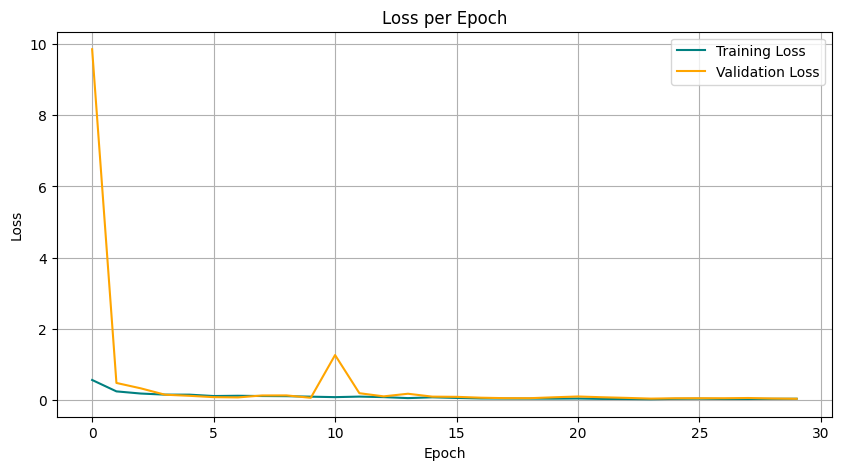

In [ ]:
# Loss
plt.figure(figsize=(10, 5))
plt.plot(hist.history.get('loss', []), color='teal', label='Training Loss')
plt.plot(hist.history.get('val_loss', []), color='orange', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

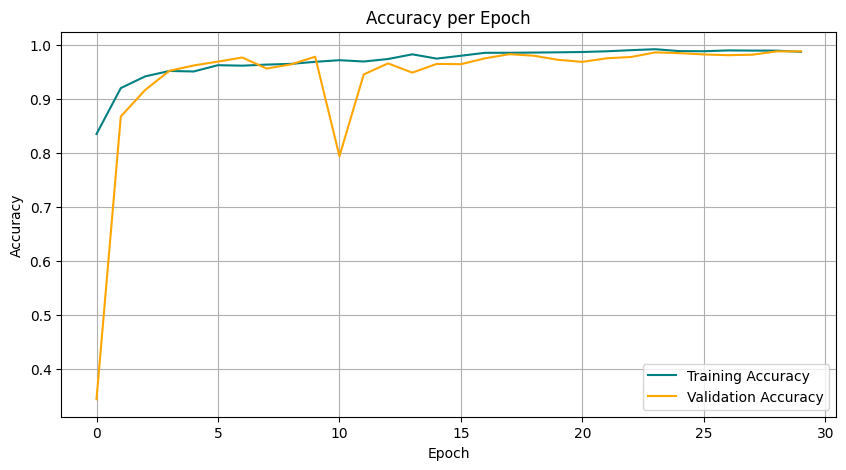

In [ ]:
# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(hist.history.get('accuracy', []), color='teal', label='Training Accuracy')
plt.plot(hist.history.get('val_accuracy', []), color='orange', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Evaluare pe Setul de Test


--- Evaluare pe setul de test ---
Se încarcă cel mai bun model salvat din: best_leaf_model.keras
Evaluare folosind model.evaluate...
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - accuracy: 0.9765 - loss: 0.1091 - precision: 0.9769 - recall: 0.9757

Rezultate model.evaluate:
Test Loss:      0.1532
Test Accuracy:  0.9637
Test Recall:    0.9629
Test Precision: 0.9644

Generare Matrice de Confuzie și Raport de Clasificare...
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step


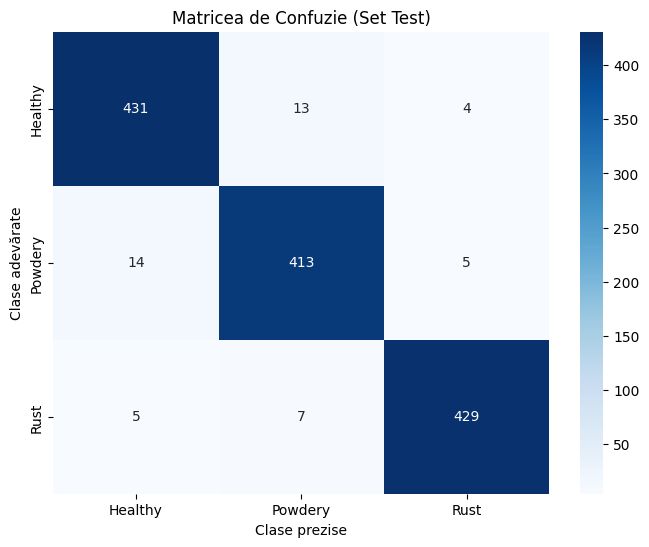


Raport de clasificare (Set Test):
              precision    recall  f1-score   support

     Healthy       0.96      0.96      0.96       448
     Powdery       0.95      0.96      0.95       432
        Rust       0.98      0.97      0.98       441

    accuracy                           0.96      1321
   macro avg       0.96      0.96      0.96      1321
weighted avg       0.96      0.96      0.96      1321



In [ ]:
print("\n--- Evaluare pe setul de test ---")
# Încarcă cel mai bun model salvat
print(f"Se încarcă cel mai bun model salvat din: {checkpoint_filepath}")
if os.path.exists(checkpoint_filepath):
    best_model = load_model(checkpoint_filepath) # Încarcă cel mai bun model

    print("Evaluare folosind model.evaluate...")
    test_loss, test_accuracy, test_recall, test_precision = best_model.evaluate(test_generator, verbose=1)
    print(f"\nRezultate model.evaluate:")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")
    print(f"Test Precision: {test_precision:.4f}")

    print("\nGenerare Matrice de Confuzie și Raport de Clasificare...")
    # Obține predicții pentru tot setul de test
    # Resetăm generatorul pentru a ne asigura că începe de la început
    test_generator.reset()
    predictions = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0) , verbose=1)
    # Obține clasele prezise (indicii cu probabilitatea maximă)
    y_pred_indices = np.argmax(predictions, axis=1)
    # Obține clasele adevărate
    y_true_indices = test_generator.classes # Acesta conține indicii claselor adevărate

    # Asigură-te că avem același număr de etichete
    if len(y_pred_indices) != len(y_true_indices):
         print(f"Atenție: Număr diferit de predicții ({len(y_pred_indices)}) și etichete adevărate ({len(y_true_indices)}). Verifică pașii de predicție.")
         # Încercăm să ajustăm dacă diferența e mică (posibil ultimul batch parțial)
         min_len = min(len(y_pred_indices), len(y_true_indices))
         y_pred_indices = y_pred_indices[:min_len]
         y_true_indices = y_true_indices[:min_len]


    # Calculează matricea de confuzie
    cm = confusion_matrix(y_true_indices, y_pred_indices)

    # Vizualizează matricea de confuzie
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Clase prezise")
    plt.ylabel("Clase adevărate")
    plt.title("Matricea de Confuzie (Set Test)")
    plt.show()

    # Afișează raportul de clasificare
    print("\nRaport de clasificare (Set Test):")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))

else:
    print(f"EROARE: Fișierul {checkpoint_filepath} nu a fost găsit. Evaluarea pe cel mai bun model nu se poate face.")


# Test pe o Imagine Individuală

In [ ]:

print("\n--- Test pe o imagine individuală ---")
test_image_path = 'download (2).jpg' # path ul

if os.path.exists(test_image_path):
    try:
        img = cv2.imread(test_image_path)
        if img is None:
            print(f"EROARE: Nu s-a putut citi imaginea: {test_image_path}")
        else:
            # Afișează imaginea originală (BGR)
             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Conversie pt matplotlib
             plt.title("Imagine Originală")
             plt.show()

             # Preprocesare IDENTICĂ cu cea de la antrenament
             # 1. Redimensionare
             img_resized = cv2.resize(img, IMG_SIZE) # Folosim cv2.resize pt consistență cu cv2.imread

             # 2. Conversie BGR -> RGB (Keras/TF se așteaptă la RGB de obicei)
             img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

             # 3. Rescalare (Împărțire la 255.0)
             img_rescaled = img_rgb / 255.0

             # 4. Adăugare dimensiune Batch (1, height, width, channels)
             img_final_for_pred = np.expand_dims(img_rescaled, axis=0)

            # Afișează imaginea procesată
             plt.imshow(img_rescaled) # Valorile vor fi [0,1]
             plt.title("Imagine Procesată (pt. Predicție)")
             plt.show()

            # Folosim cel mai bun model
             if 'best_model' in locals() or 'best_model' in globals():
                 print("Se face predicția folosind best_model...")
                 yhat = best_model.predict(img_final_for_pred)

                 print("Probabilități predicție:", yhat)

                 # Obține indexul clasei cu cea mai mare probabilitate
                 predicted_class_index = np.argmax(yhat[0])
                 # Obține numele clasei
                 predicted_class_name = class_names[predicted_class_index]
                 # Obține încrederea (probabilitatea)
                 confidence = yhat[0][predicted_class_index]

                 print(f"\nClasa prezisă: {predicted_class_name} (Index: {predicted_class_index})")
                 print(f"Încredere: {confidence:.4f}")
             else:
                 print("Obiectul 'best_model' nu a fost încărcat. Predicția nu se poate face.")

    except Exception as e_pred:
        print(f"A apărut o eroare la procesarea imaginii de test: {e_pred}")
else:
    print(f"EROARE: Imaginea de test '{test_image_path}' nu a fost găsită.")


In [ ]:
# --- Salvare Model Final (Opțional, diferit de cel mai bun salvat de checkpoint) ---
# print("\n--- Salvare model final (ultima epocă) ---")
# models_dir = 'models_final'
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# Salvează modelul din ultima stare (nu neapărat cel mai bun)
# include_optimizer=True salvează și starea optimizatorului, util pt reluarea antrenamentului
# model.save(os.path.join(models_dir, 'leaf_classifier_final_epoch.keras'), include_optimizer=True)
# print(f"Modelul final salvat în {models_dir}")


from google.colab import files
if os.path.exists(checkpoint_filepath):
   print(f"\nDescarcă cel mai bun model salvat: {checkpoint_filepath}")
   files.download(checkpoint_filepath)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 # OpenCV pentru citirea imaginii
import os


# 1. Specifică calea către modelul tău antrenat (.keras)
PATH_MODEL_ANTRENAT = '/content/best_leaf_model (1).keras'

# 2. Specifică calea către noua imagine pe care vrei să o clasifici
PATH_IMAGINE_NOUA = '/content/download (1).jpg'

# 3. Dimensiunea imaginii folosită la antrenament
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299

# 4. Numele claselor (în ordinea indexului dat de train_generator.class_indices)
#    Verifică outputul celulei cu train_generator.class_indices dacă ordinea e alta!
CLASS_NAMES = ['blight', 'healthy', 'powdery', 'rust']


# Verifică existența fișierelor
if not os.path.exists(PATH_MODEL_ANTRENAT):
    print(f"EROARE: Modelul nu a fost găsit la calea: {PATH_MODEL_ANTRENAT}")
elif not os.path.exists(PATH_IMAGINE_NOUA):
    print(f"EROARE: Imaginea nu a fost găsită la calea: {PATH_IMAGINE_NOUA}")
else:
    print("--- Încărcare model ---")
    try:
        #modelul salvat
        model = tf.keras.models.load_model(PATH_MODEL_ANTRENAT)
        print("Model încărcat cu succes.")
        # model.summary() #afișează structura modelului

        print("\n--- Preprocesare Imagine ---")
        # Încarcă imaginea nouă
        img = cv2.imread(PATH_IMAGINE_NOUA)
        if img is None:
            print(f"EROARE: Nu s-a putut citi imaginea de la: {PATH_IMAGINE_NOUA}")
        else:
            # Convertește din BGR în RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Redimensionează imaginea la dimensiunea de model
            img_resized = cv2.resize(img_rgb, (IMAGE_WIDTH, IMAGE_HEIGHT))

            # Normalizează pixelii
            img_normalized = img_resized / 255.0

            #
            # Forma devine (1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
            img_batch = np.expand_dims(img_normalized, axis=0)
            print(f"Imagine preprocesată, forma: {img_batch.shape}")

            print("\n--- Realizare Predicție ---")
            # Realizează predicția
            predictions = model.predict(img_batch)
            print(f"Probabilități predicție: {predictions[0]}") # Afișează vectorul de probabilități

            # Găsește indexul clasei cu cea mai mare probabilitate
            predicted_class_index = np.argmax(predictions[0])

            # Găsește numele clasei și scorul de încredere
            predicted_class_name = CLASS_NAMES[predicted_class_index]
            confidence_score = np.max(predictions[0])

            print(f"\nClasa prezisă: {predicted_class_name} (Index: {predicted_class_index})")
            print(f"Încredere: {confidence_score:.4f}")

            # Afișează imaginea
            import matplotlib.pyplot as plt
            plt.imshow(img_resized) # Afișează imaginea redimensionată (nu normalizată)
            plt.title(f"Predicție: {predicted_class_name} ({confidence_score:.2f})")
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"A apărut o eroare: {e}")

EROARE: Modelul nu a fost găsit la calea: /content/best_leaf_model (1).keras
